# NYC Taxi Fare Prediction: Multiple Linear Regression

The dataset is provided by Google. It is very large dataset having around 50M records. The decription of the features are avilable in Data section at Kaggle.

There are two main files. 
1. **train.csv **(We will use this to perform EDA, build and train our model.)
2. **test.csv** (We will use this file to validate our model by generating predictions.)

For an excellent EDA you can refer to <a href="https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration">NYC Taxi Fare: Data Exploration.</a> kernel on Kaggle.

## Multiple Linear Regression: 

We all knows that multiple linear regression is used on problems having more than 1 independent variables. Here,
independent variables means features(columns of dataset), which are used to predict target variable (dependent
variable). But, before implementing MLR directly, we know that MLR makes several assumptions which are required to be
true for the best performance of the algorithm. 
    
So, I will first perform Exploratory Data Analysis(EDA) to gain some valuable information from dataset and then validate
each assumption of Linear Regression. Let me briefly state the assumptions.  

> **Assumptions of Linear Regression:**
1. Relationship between your independent and dependent variables should always be linear.
2. Mean of residuals should be zero or close to 0 as much possible.
3. There should be **homoscedasticity** or equal variance in our regression model. 
4. All the dependent variables and residuals should be uncorrelated.
5. Number of observations should be greater than number of independent variables.
6. There should be no perfect **multicollinearity** in your model.
7. Residuals should be normally distributed.


It is perfectly fine if some of the terms described in assumptions are not familiar. E.g, Homoscedasticity. I will go in more detail of each of the assumption while validating them.

In [1]:
# Importing necessary dependecies

import pandas as pd
import numpy as np
#import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load training dataset. Remember that data is too large. So, we will load a portion of data

df_train = pd.read_csv(r"C:\Users\Hemang\NYC Taxi Data\train.csv", sep=",", nrows= 4_000_000)

Let's slicing off unecessary components of the datetime and specify the date format. This will results in a more efficiecnt conversion to a datetime object.

In [3]:
df_train.pickup_datetime = df_train.pickup_datetime.str.slice(0,16)

In [4]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format = '%Y-%m-%d %H:%M')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 244.1+ MB


In [6]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.000000e+06,4.000000e+06,4.000000e+06,3.999971e+06,3.999971e+06,4.000000e+06
mean,1.134395e+01,-7.250844e+01,3.991910e+01,-7.250871e+01,3.991789e+01,1.684334e+00
std,9.824543e+00,1.312180e+01,8.797868e+00,1.289308e+01,9.716855e+00,1.329071e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076711e+01,-7.396366e+01,4.076812e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


## Data Cleaning: 

There are few important observation from this description of dataset.

* Minimum fare_amount is negative, which is quite unrealistic in the scenario. I will drop those fields.  
* Notice that some minimum and maximum longitude/latitude are off the boundary of New York city. I will also remove those. May be, I will define boundary for longitude/lattitude(lat: 40.7141667, long:  -74.0063889) to remove outliers.
* Also, maximum passenger_count is 208, which is also an outlier. I will drop those records too.


In [8]:
# Filter out negative fare amount and maximum passenger_count
print("Old Size Before Filter: %d" %(len(df_train)))
df_train = df_train[(df_train.fare_amount >=0) & (df_train.passenger_count <=10)]
print("New Size After Filter: %d" %(len(df_train)))

Old Size Before Filter: 4000000
New Size After Filter: 3999825


I am refering <a href="https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration">this kernel </a> for EDA. It is really an inspiring one and have very deep analysis of data. There are many good explorations in that kernel that, I have used here.

Text(0.5,1,'Fare Amount Distribution')

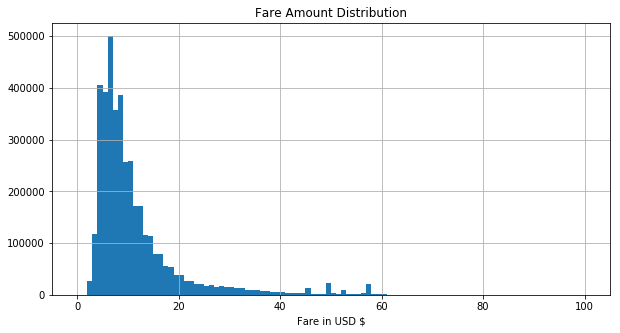

In [9]:
# Let's plot histogram of fare_amount to see its distribution across data.

df_train[df_train.fare_amount < 100].fare_amount.hist(bins=100, figsize=(10,5))
plt.xlabel("Fare in USD $")
plt.title("Fare Amount Distribution")

In the histogram of the fare_amount there are some small spikes between USD 40 and USD 60. This could indicate some fixed fare price (e.g. to/from airport). That is further explored in <a href="https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration">NYC Taxi Fare: Data Exploration.</a>

Let's check for missing or null values present in the dataset. It would not affect model if we remove those null values as the dataset is large.

In [10]:
print(df_train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    29
dropoff_latitude     29
passenger_count       0
dtype: int64


In [11]:
print("Old Size : %d" %(len(df_train)))
df_train=df_train.dropna(axis = 0)
print("New Size: %d" %(len(df_train)))

Old Size : 3999825
New Size: 3999796


As we know that, some data oints have minimum and maximum lattitude/longitude off the boundary of NYC. So, we have to filter those outliers too.

In [12]:
# Filtering out off boundary points. Boundary of New York City is (-75, -73, 40, 42)
def NYC(df):
    boundary_filter = (df.pickup_longitude >= -75) & (df.pickup_longitude <= -73) & \
                      (df.pickup_latitude >= 40) & (df.pickup_latitude <= 42) & \
                      (df.dropoff_longitude >= -75) & (df.dropoff_longitude <= -73) & \
                      (df.dropoff_latitude >= 40) & (df.dropoff_latitude <= 42)
    df = df[boundary_filter]
    return df

In [13]:
print('Old size: %d' % len(df_train))
df_train = NYC(df_train)
print('New size: %d' % len(df_train))

Old size: 3999796
New size: 3915628


### Computing Distance :

We know that **"Manhattan Distance"** metric will give us better approximation of distance between two points in given plane.So, we will use manhattan distance formula to compute distance between pickup and dropoff points.

In [14]:
def distance_between_pickup_dropoff(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    d = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    return d

### Extracting New Features:

I have used taxi many times (e.g Uber) to travel from school to home and home to school. In my general observation I have found many interesting facts about fare prices. 


1. The fare amount was high in peak hours. (for ex: Morning and Night time)
2. The fare amount was high during bad weathers too. (snow or thunder storm)
3. The fare amount was high on holidays and sometimes in weekends.
4. The fare amount was low in afternoons and before noon.

From this observations, I can say that time is also one of the factors affecting fare_amount. So, we can use features like "hour" and "day". Also, we can consider "month" and "year"  too as features and see if those affects fare_amount.


In [15]:
# Extracting Features 

df_train['hour'] = df_train.pickup_datetime.dt.hour
df_train['day'] = df_train.pickup_datetime.dt.day
df_train['month'] = df_train.pickup_datetime.dt.month
df_train['year'] = df_train.pickup_datetime.dt.year
df_train.drop('pickup_datetime', axis =1, inplace = True)

# Creating actual_distance column as measure of manhattan distance

df_train['actual_distance'] = distance_between_pickup_dropoff(df_train.pickup_latitude, df_train.pickup_longitude,
                                                             df_train.dropoff_latitude, df_train.dropoff_longitude)

In [16]:
# Let's check how our new data set looks like.

df_train.head(8)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,actual_distance
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0.011742
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,0.107481
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,0.019212
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,0.029386
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,0.027194
5,2011-01-06 09:50:45.0000002,12.1,-74.000964,40.731630,-73.972892,40.758233,1,9,6,1,2011,0.054675
6,2012-11-20 20:35:00.0000001,7.5,-73.980002,40.751662,-73.973802,40.764842,1,20,20,11,2012,0.019380
7,2012-01-04 17:22:00.00000081,16.5,-73.951300,40.774138,-73.990095,40.751048,1,17,4,1,2012,0.061885


## Visualization

We have latitude and longitude values. So, we can use those to plot the data and see what will come up.

Here, I am using pickup_latitude and pickup_longitude. We can generate smae plot for dropoff_latitude and dropoff_longitude too.

In [17]:
# Here, i am bounding the longitude and latitude values to get clear and zoomed plot.
df_plot = df_train[(df_train.pickup_longitude >= -74.1)&(df_train.pickup_longitude <= -73.8) & (df_train.pickup_latitude >=40.6)
                  & (df_train.pickup_latitude <=40.9)]

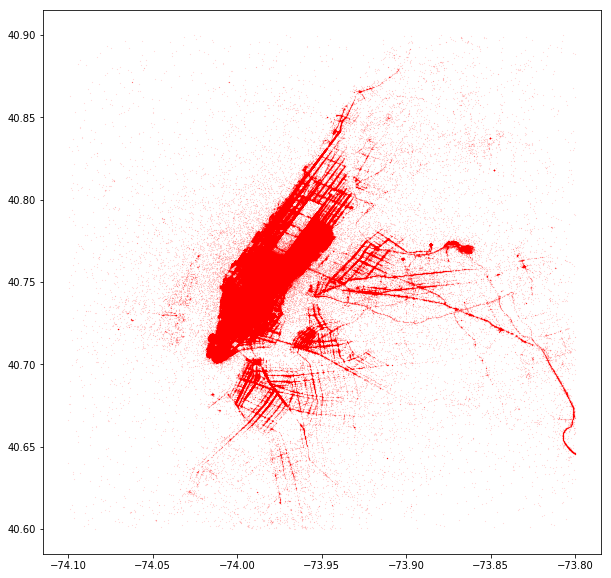

In [18]:
# In scatter plot arguments c = 'r' is "color red", s= 0.01 is "size of dots" and alpha = 0.5 is "opacity of dots"
fig, ax = plt.subplots(1, 1, figsize=[10,10])
ax.scatter(df_plot.pickup_longitude, df_plot.pickup_latitude,c = 'r', s= 0.01,alpha=0.5)

In [19]:
# Let's zoom little more

zoomed_data =  df_train[(df_train.pickup_longitude >= -74.02)&(df_train.pickup_longitude <= -73.95) & (df_train.pickup_latitude >=40.7)
                  & (df_train.pickup_latitude <=40.80)]

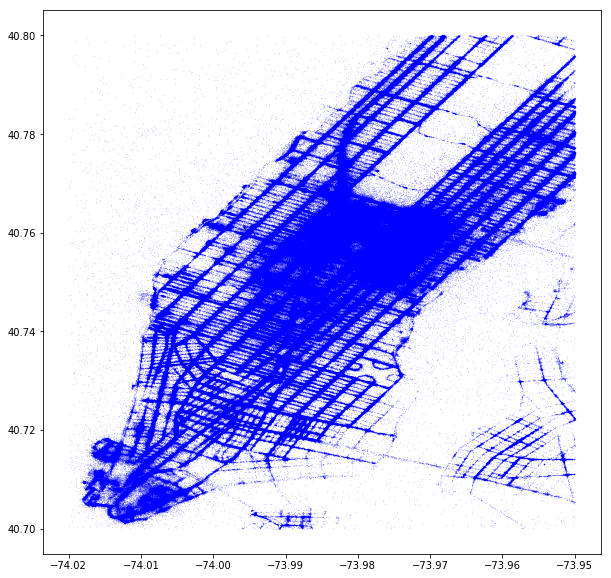

In [20]:
fig, ax = plt.subplots(1, 1, figsize=[10,10])
ax.scatter(zoomed_data.pickup_longitude, zoomed_data.pickup_latitude,c = 'b', s= 0.01,alpha=0.5)

## Building a Model:

It's time to build a model for training. I will use Linear Regression model of Scikit learn library. I will also measure RMSE(Root Mean Squared Error) to check accuracy of training set and test set.

In [108]:
# Let's create feature vector
# We do not want trip involving 0 passenger_count
filt = (df_train.passenger_count > 0) & (df_train.fare_amount < 250)
features = ['passenger_count','hour','year','day','month','actual_distance']

In [109]:
for f in features:
    related = df_train.fare_amount.corr(df_train[f])
    print("%s: %f" % (f,related))

passenger_count: 0.014415
hour: -0.017403
year: 0.115963
day: 0.001020
month: 0.024587
actual_distance: 0.805713


In [110]:
final_features =['year','hour','actual_distance','passenger_count']

In [111]:
X = df_train[filt][final_features].values # Feature Vector
Y = df_train[filt]['fare_amount'].values # Target Variable

In [112]:
X.shape, Y.shape

((3901700, 4), (3901700,))

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [126]:
# Splitting data set into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [127]:
regressor = LinearRegression()

In [128]:
metric = 'neg_mean_squared_error'
scores = cross_val_score(regressor, X_test, y_test, cv = 10, scoring = metric)

In [129]:
scores

array([-33.92463862, -30.2584038 , -32.91461186, -31.9494808 ,
       -29.01911503, -30.34086062, -28.82621714, -31.67689824,
       -30.43099195, -29.75548695])

In [130]:
np.sqrt(np.abs(scores))

array([ 5.82448612,  5.50076393,  5.73712575,  5.65238718,  5.3869393 ,
        5.50825386,  5.36900523,  5.62822336,  5.51642928,  5.45485902])

In [131]:
np.sqrt(np.abs(scores.mean()))

5.5596466165919143

In [132]:
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
y_train_pred = regressor.predict(X_train)

In [35]:
def error(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [134]:
rmse = error(y_train, y_train_pred)

In [135]:
rmse

5.597040489102354

In [136]:
y_test_pred = regressor.predict(X_test)

In [137]:
rmse = error(y_test, y_test_pred)

In [138]:
rmse

5.559218440102943

In [139]:
from sklearn.linear_model import Lasso

In [140]:
alphas =[1e-5,1e-3, 1e-2, 0.02, 0.04,0.08,0.1]

In [141]:
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_train_pred = lasso.predict(X_train)
    rmse = error(y_train, y_train_pred)
    print("alpha : {%.5f} RMSE : {%.9f}" %(alpha,rmse))

alpha : {0.00001} RMSE : {5.597040492}
alpha : {0.00100} RMSE : {5.597072094}
alpha : {0.01000} RMSE : {5.600200046}
alpha : {0.02000} RMSE : {5.609668035}
alpha : {0.04000} RMSE : {5.647381254}
alpha : {0.08000} RMSE : {5.795646018}
alpha : {0.10000} RMSE : {5.904272673}


In [142]:
lasso = Lasso(alpha = 0.01)

In [143]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
y_test_pred = lasso.predict(X_test)

In [145]:
rmse = error(y_test, y_test_pred)

In [146]:
rmse

5.5652466698516863

## Validating Assumptions

### Assumption 1: Relationship between independent and dependent variables should always be linear

Text(0.5,0,'actual_distance')

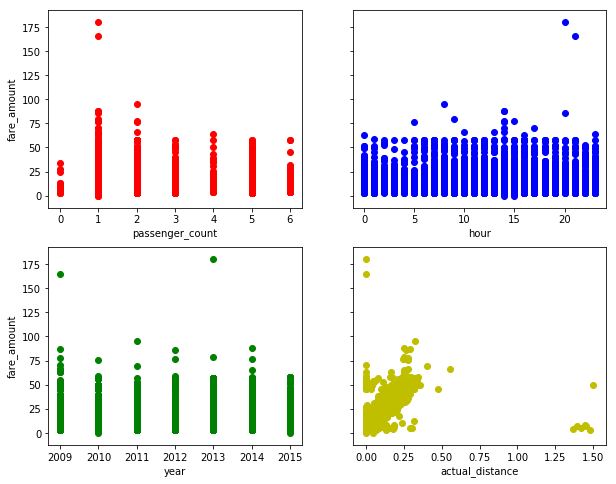

In [107]:
fig, ax = plt.subplots(2,2, figsize=[10,8], sharey = True)
ax[0,0].scatter(df_train.passenger_count[:10000], df_train.fare_amount[:10000], c='r')
ax[0,0].set_xlabel("passenger_count")
ax[0,0].set_ylabel("fare_amount")
ax[0,1].scatter(df_train.hour[:10000], df_train.fare_amount[:10000], c='b')
ax[0,1].set_xlabel("hour")
ax[1,0].scatter(df_train.year[:10000], df_train.fare_amount[:10000], c='g')
ax[1,0].set_xlabel("year")
ax[1,0].set_ylabel("fare_amount")
ax[1,1].scatter(df_train.actual_distance[:10000], df_train.fare_amount[:10000], c='y')
ax[1,1].set_xlabel("actual_distance")

### Assumption 2: Mean of residuals should be 0 or close to 0

In [51]:
residuals_test = y_test_pred - y_test
np.mean(residuals_test)

-0.0090377426557825338

In [53]:
residuals_train = y_train_pred - y_train
np.mean(residuals_train)

-1.2187016103783478e-13

### Assumption 3:  There should be Homoscedasticity or equal variance in our regression model.
This assumption means that the variance around the regression line is the same for all values of the predictor variable (X). 
The plot does not show "funnel" shape (or ice cream cone shape). Which means there is no Heteroscedasticity. Or there is Homoscedasticity or equal variance in model.

Text(0.5,1,'Residuals vs. Predicted')

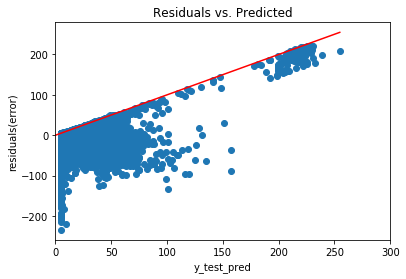

In [104]:
residuals = list(y_test_pred - y_test)
minimum = min(np.min(y_test_pred), np.min(residuals))
maximum = max(np.max(y_test_pred), np.max(residuals))
fig,ax = plt.subplots(1,1, figsize=[6,4])
ax.scatter(y_test_pred, residuals)
ax.plot([minimum, maximum], [minimum,maximum], c='r')
ax.set_xlabel("y_test_pred")
ax.set_ylabel("residuals(error)")
ax.set_xlim(0,300)
ax.set_title("Residuals vs. Predicted")

### Assumption 4:  All the dependent variables and residuals should be uncorrelated.

Here we can see no correlations. 

In [55]:
residuals = np.array(y_test_pred - y_test)

In [56]:
df_residual = pd.DataFrame(residuals, index = np.arange(len(residuals)),columns = ["residual"])

In [57]:
for feature in final_features:
    related = df_residual.residual.corr(df_train[feature])
    print("%s: %f" % (feature,related))

passenger_count: 0.001507
hour: 0.000677
year: -0.000379
actual_distance: 0.000458


### Assumption 5: Number of observations should be greater than number of independent variables. 

Which is we can verify by looking at data set size and number of features. 

### Assumption 6: There should be no perfect multicollinearity in your model.
Multicollinearity or collinearity is important factor affecting coefficient of regression model. The more varience you see in model the more unstable the model is. The model has multicollinearity when one or more of predictor variables(independent variables) are highly correlated with target variable(dependent variable). So, following scenario may happen in case of multicollinearity.

1. When you add or delete an X variable, the regression coefficients change dramatically.
2. You see a negative regression coefficient when your response should increase along with X.
3. You see a positive regression coefficient when the response should decrease as X increases.
4. Your X variables have high pairwise correlations. 

One way to measure multicollinearity is the variance inflation factor (VIF), which assesses how much the variance of an estimated regression coefficient increases if your predictors are correlated.  If no factors are correlated, the VIFs will all be 1.

>VIF : A value of 1 indicates that there is no correlation between this independent variable and any others. VIFs between 1 and 5 suggest that there is a moderate correlation, but it is not severe enough to warrant corrective measures. VIFs greater than 5 represent critical levels of multicollinearity where the coefficients are poorly estimated, and the p-values are questionable.


In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [60]:
vif = pd.DataFrame()

In [66]:
X[:2]

array([[  1.00000000e+00,   1.70000000e+01,   2.00900000e+03,
          1.17420000e-02],
       [  1.00000000e+00,   1.60000000e+01,   2.01000000e+03,
          1.07481000e-01]])

In [64]:
vif['VIF Factors'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['features'] = final_features

In [65]:
vif.head()

,VIF Factors,features
0,2.676879,passenger_count
1,5.307173,hour
2,7.653193,year
3,1.690293,actual_distance


In [83]:
#Removing features with high VIF > 5.0
final_feature_list = ['passenger_count','actual_distance']
X = df_train[filt][final_feature_list].values # Feature Vector
Y = df_train[filt]['fare_amount'].values # Target Variable

In [84]:
X.shape, Y.shape

((3901700, 2), (3901700,))

### Assumption 7: Residuals should be normally distributed.
We can see from figure that residuals are normally distributed as we can observe bell shaped curve in Histogram Distribution.

Text(0.5,0,'Residuals')

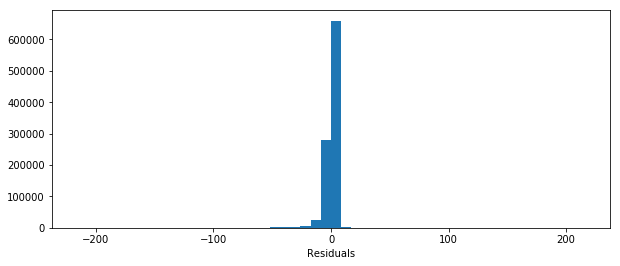

In [102]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.hist(residuals, bins = 50)
ax.set_xlabel("Residuals")

# Model selection Problem:


<p id="modelSelection">What we need to do to select better model for our dataset?</p>

1. Select the model type (e.g Linear)
2. Select the hypothesis (e.g. Lasso(Regularized Linear Regression), Ridge(Regularized Linear Regression), Linear Regression)
3. Select the range of degree of polynomial to set on your model. (d = 10)
4. Iterate over degree of polynomial. 
    1. While iterating, For each degree of polynomial (means for each hypothesis generated by degree of polynomial)<br> 
    For example, hypothesis $$h_\theta(x) = \theta_0 + \theta_1 x ...d=1$$ $$h_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2 ... d=2$$ $$h_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 ...d=3$$
    
    2. Compute training set error for each hypothesis
    3. Compute cross-validation error (here in our case test set error) for each hypothesis
    4. Choose the best polynomial hypothesis with degree(d) having lowest validation error
 
5. Select the best model for testing and prediction.

# Diagnosing Bias vs. Variance:

How do we know that our learning algorithm is suffering from either **"High Bias"** problem or **"High Variance"** problem?


The **training error** will tend to **decrease** as we increase the **degree** d of the polynomial.

At the same time, the **cross validation error** will tend to **decrease** as we increase d up to a point, and then it will **increase as d is increased**, forming a convex curve.
<img src="snap-1.jpg"/>

1. **High Bias** : Both training and cross validation will be high. $J_{cv}(\theta) \approx J_{train}(\theta)$
2. **High Variance** : Training error will be low and cross validation will be much higher. $J_{cv}(\theta)\gg J_{train}(\theta)$

# Automatically Choosing Regularization Parameter ($\lambda$):

> Remember: Here we already got the higher order polynomial as our hypotheses from <a href="#modelSelection"> Model Selection.</a>

Let say we have a model with high order polynomial hypothesis $h_\theta(x)$. And have a cost function $J(\theta)$ with regularization parameter $\lambda$. 

How to choose $\lambda$ ?

1. Define range of values of $\lambda$ ($\lambda$ = [0.0, 0.01, 0.02, 0.04, 0.06, 0.08,...., 10.24])
2. For given hypotheses $h_\theta(x)$ iterate over $\lambda$ go through all models and learn parameter vector $\Theta$.
3. Compute values of error $J_{cv}(\theta)$ without regularization(or $\lambda = 0$) for each $\Theta$. 
4. Select the best combo that produces the lowest value of $J_{cv}(\theta)$.
5. Using the best combo $\Theta$ and $\lambda$, apply it on $J_{test}(\Theta)$ to see if it has a good generalization of the problem.


# Learning Curves:

Learning curves being plot to determine whether our learning algorithm is suffering from **"Bias"** problem or **"Variance"** problem or bit of both problem.

Training an algorithm on a very few number of data points (such as 1, 2 or 3) will easily have 0 errors because we can always find a quadratic curve that touches exactly those number of points. Hence:

* As the training set gets larger, the error for a quadratic function increases.
* The training error will flatten out after a certain number of training examples(or m) or training set size.


1. **Experiencing High Bias**: 
    1. **Low Training Set Size**: Causes $J_{train}(\theta)$ to be low and $J_{cv}(\theta)$ to be high.
    2. **Large Training Set Size**: Causes both $J_{train}(\theta)$ and $J_{cv}(\theta)$ to be high with $J_{train}(\theta)\approx J_{cv}(\theta)$
    If a learning algorithm is suffering from **high bias**, getting more training data will not (**by itself**) help much.
<img src="snap-2.jpg"/>

2. **Experiencing High Variance**:
    1. **Low Training Set Size**: Causes $J_{train}(\theta)$ will be low and $J_{cv}(\theta)$ will be high.
    2. **Large Training Set Size**: $J_{train}(\theta)$  increases with training set size and $J_{cv}(\theta)$ continues to decrease without leveling off. Also, $J_{train}(\theta) < J_{cv}(\theta)$ but the difference between them remains significant.
    If a learning algorithm is suffering from **high variance**, getting more training data is likely to help.

<img src="snap-3.jpg"/>

In [269]:
from sklearn.tree import DecisionTreeRegressor

In [290]:
reg = DecisionTreeRegressor(max_depth = 10)

In [291]:
reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [292]:
y_trn_pred = reg.predict(X_train)

In [293]:
rmse = error(y_train, y_trn_pred)

In [294]:
rmse

4.6018230358434229

In [295]:
y_tst_pred = reg.predict(X_test)

In [296]:
rmse = error(y_test, y_tst_pred)

In [297]:
rmse

4.7155101530367798